# Code Enforcement 2018-2021

## Import Data and Explore

In [46]:
import pandas as pd
import numpy as np
import datetime

In [47]:
#import data
code_data_df = pd.read_csv(r'C:\Users\nrebovich\Desktop\NRC\Accela\Data\Enforce\All Code Records by Date.csv')

In [48]:
#look at data
code_data_df.head()

,RECORD ID,PARCEL NBR,DATE OPENED,RECORD TYPE,RECORD MODULE,RECORD STATUS,RECORD STATUS DATE,TOTAL INVOICED,TOTAL PAID,DESCRIPTION
0,17200-00001,930812,1/3/2017,Other Multiple Violations,Enforce,Completed,1/4/2017,$0.00,$0.00,(Old Charlie D's Fish Place)-Windows are all b...
1,17200-00003,72242,1/3/2017,Other Multiple Violations,Enforce,Completed,1/24/2019,$0.00,$0.00,"LUMBER, TIRES AND RUBBISH ON THE PROEPRTY. REP..."
2,17200-00004,93601,1/3/2017,Other Multiple Violations,Enforce,Completed,4/10/2017,$0.00,$0.00,NaN
3,17200-00005,69156,1/3/2017,Other Multiple Violations,Enforce,Completed,2/16/2017,$0.00,$0.00,NaN
4,17200-00006,121809,1/3/2017,Other Multiple Violations,Enforce,Completed,1/13/2017,$0.00,$0.00,NaN


In [49]:
#check null values
code_data_df.isnull().sum()

RECORD ID                 0
PARCEL NBR                1
DATE OPENED               0
RECORD TYPE               0
RECORD MODULE             0
RECORD STATUS           962
RECORD STATUS DATE        0
TOTAL INVOICED            0
TOTAL PAID                0
DESCRIPTION           43301
dtype: int64

In [50]:
#check count of record types
code_data_df['RECORD TYPE'].value_counts()

Other Multiple Violations                                          18573
Code Admin Citation                                                11547
14 Day Abatement Weeds                                              9967
Rental License                                                      8227
Rental License Inspection                                           6350
                                                                   ...  
Prof Scientific Tech Services - Computer Systems Design Service        1
DRC New Non-Residential Bldg                                           1
Other Services not Public - Death Care Services                        1
Transportation Warehousing - Ambulance Driver                          1
Other Services not Public - Automotive Repair and Maint                1
Name: RECORD TYPE, Length: 319, dtype: int64

***

## Cleaning Data

In [51]:
#convert description and record type columns to lower to make searching easier
code_data_df['DESCRIPTION'] = code_data_df['DESCRIPTION'].str.lower()
description_series = code_data_df['DESCRIPTION']
code_data_df['RECORD TYPE'] = code_data_df['RECORD TYPE'].str.lower()

In [52]:
#convert date opened and date status columns to datetime
code_data_df['DATE OPENED'] = pd.to_datetime(code_data_df['DATE OPENED'])
code_data_df['RECORD STATUS DATE'] = pd.to_datetime(code_data_df['RECORD STATUS DATE'])
code_data_df.dtypes

RECORD ID                     object
PARCEL NBR                    object
DATE OPENED           datetime64[ns]
RECORD TYPE                   object
RECORD MODULE                 object
RECORD STATUS                 object
RECORD STATUS DATE    datetime64[ns]
TOTAL INVOICED                object
TOTAL PAID                    object
DESCRIPTION                   object
dtype: object

In [53]:
code_data_df = code_data_df.dropna(subset=['DATE OPENED'])

In [54]:
#create OPEN YEAR column that returns year of code violation
open_year = []

for i in range(len(code_data_df['DATE OPENED'])):
    open_year.append(code_data_df.loc[i,'DATE OPENED'].year)
    
code_data_df['OPEN YEAR'] = open_year
code_data_df['OPEN YEAR'] = code_data_df['OPEN YEAR'].astype(int)

In [55]:
code_data_df.dtypes

RECORD ID                     object
PARCEL NBR                    object
DATE OPENED           datetime64[ns]
RECORD TYPE                   object
RECORD MODULE                 object
RECORD STATUS                 object
RECORD STATUS DATE    datetime64[ns]
TOTAL INVOICED                object
TOTAL PAID                    object
DESCRIPTION                   object
OPEN YEAR                      int32
dtype: object

In [56]:
enforce_data = code_data_df[(code_data_df['RECORD MODULE'] == 'Enforce')].copy()
enforce_data = enforce_data.reset_index(drop=True)
enforce_2017_data = code_data_df[(code_data_df['RECORD MODULE'] == 'Enforce') & (code_data_df['OPEN YEAR'] == 2017)]
enforce_2021_data = code_data_df[(code_data_df['RECORD MODULE'] == 'Enforce') & (code_data_df['OPEN YEAR'] == 2021)]

In [57]:
#Create 4 blank columns to store record type for other multiple violations
enforce_data['New Record Type'] = 'NaN'
enforce_data['New Record Type 1'] = 'NaN'
enforce_data['New Record Type 2'] = 'NaN'
enforce_data['New Record Type 3'] = 'NaN'

In [58]:
enforce_2021_data['RECORD TYPE'].value_counts()

code-environment                4878
abatement                       3185
enforcement complaint           2759
code admin citation             2579
structural                       722
vpr compliance                   528
tow                              278
graffiti                         200
qrtt quick response              177
vacant property registration     170
unsecure structure               169
unfit                            114
fire damage                      105
zoning pmc                        88
boarding permit                   44
Name: RECORD TYPE, dtype: int64

---

## Converting "other multiple violations"

In [59]:
#create dictionary where key is record type and items are search terms associated with that record type
#for example if 'brush' is found in the description of an other multiple violations record,
#it will be counted as a environmental record type

search_dict =  {
    'Environmental' : [
        'environment', 'brush','limb','vehicle','tree','couch','mattress','branch',
        'sofa', 'tire', 'lumber', 'vegetation', 'yard','furniture','chair','tag','gravel',
        'enviromental','car','boat','pool','driveway','window', 'excess item', 'fence line'
                       ],
    'Abatement': [
        'weeds','grass', 'junk','trash','debris','rubbish'
    ],
    
    'Code Admin Citation': ['code admin citation'],
    
    'Structural': [
        'structural','structual','repair','fence','paint','siding','roof',
        'excess stored','fenc','dumpster','tarp','gutter','alley','soffit',
        'storage','fascia','eave','house numb','address numb','appliance','garage'
    ],
    
    'Unfit': ['unfit', 'utilities','unsecure','vacant'],
    
    'Fire Damage': ['fire damage','fire'],
    'Graffiti': ['graffiti'],
    'Abatement': ['abatement'],
    'Enforcement': ['enforcement'],
    'Vacant Property Registration': ['vacant','vacant property registration','enforce/vpr/na/na'],
    'VPR Compliance': ['vpr compliance','Code Admin Citation - VPR'],
    'TOW': ['tow'],
    'QRTT quick response': ['qrtt quick response','quick response trash abatement'],
    'Zoning PMC': ['zoning'],
    'Boarding Permit': ['boarding permit','boarded structure'],
    'Unsecure Structure': ['unsecure structure','unsecure']
       }

#list of record types
record_type_series = ['environment','enforcement','code admin citation','structural','unfit','fire damage','graffiti']

In [61]:
#Reassign record type, updates old record type name to new name
#If record type is other multiple violations, will search description to try and assign correct new record type
#other multiple violations can be assigned more than one record type, subsequent record type will be added in new record type 1,2, or 3


for key in search_dict:
    
    #convert description and record type columns to series
    descr_series = enforce_data['DESCRIPTION'].str.contains('|'.join(search_dict[key]))
    type_series = enforce_data['RECORD TYPE'].str.contains('|'.join(search_dict[key]))
    
    for i in range(len(descr_series)):  
        if (enforce_data.loc[i,'RECORD TYPE'] != 'other multiple violations') & (type_series[i] == True):
            enforce_data.iloc[i,-4] = key
        elif ((descr_series[i] == True) | (type_series[i] == True)) & (enforce_data.iloc[i,-4] == 'NaN') & (enforce_data.loc[i,'RECORD TYPE'] == 'other multiple violations'):
            enforce_data.iloc[i,-4] = key
        elif (descr_series[i] == True) & ((enforce_data.iloc[i,-3] == 'NaN') & (enforce_data.iloc[i,-4] != key)) & (enforce_data.loc[i,'RECORD TYPE'] == 'other multiple violations'):
            enforce_data.iloc[i,-3] = key
        elif (descr_series[i] == True) & ((enforce_data.iloc[i,-2] == 'NaN') & (enforce_data.iloc[i,-3] != key)) & (enforce_data.loc[i,'RECORD TYPE'] == 'other multiple violations'):
            enforce_data.iloc[i,-2] = key
        elif (descr_series[i] == True) & ((enforce_data.iloc[i,-1] == 'NaN') & (enforce_data.iloc[i,-2] != key)) & (enforce_data.loc[i,'RECORD TYPE'] == 'other multiple violations'):
            enforce_data.iloc[i,-1] = key

In [62]:
enforce_2017_data = enforce_data[enforce_data['OPEN YEAR'] == 2017]
enforce_2018_data = enforce_data[enforce_data['OPEN YEAR'] == 2018]
enforce_2019_data = enforce_data[enforce_data['OPEN YEAR'] == 2019]
enforce_2020_data = enforce_data[enforce_data['OPEN YEAR'] == 2020]
enforce_2021_data = enforce_data[enforce_data['OPEN YEAR'] == 2021]

In [65]:
enforce_data['New Record Type'].value_counts()

Environmental                   23935
Abatement                       21736
Code Admin Citation             11759
NaN                              9575
Structural                       6297
Graffiti                         3003
Enforcement                      2858
QRTT quick response              1886
Boarding Permit                  1198
Unfit                             805
VPR Compliance                    528
Fire Damage                       525
Vacant Property Registration      375
TOW                               284
Unsecure Structure                186
Zoning PMC                        110
Name: New Record Type, dtype: int64

In [66]:
enforce_data['New Record Type 1'].value_counts()

NaN                             82905
Structural                       1733
Unfit                             202
Vacant Property Registration       88
Fire Damage                        44
Unsecure Structure                 37
Zoning PMC                         20
Graffiti                           11
Boarding Permit                    10
TOW                                10
Name: New Record Type 1, dtype: int64

In [67]:
enforce_data['New Record Type 2'].value_counts()

NaN                             84924
Unfit                              48
Vacant Property Registration       36
Unsecure Structure                 31
Fire Damage                        13
Boarding Permit                     3
TOW                                 3
Graffiti                            2
Name: New Record Type 2, dtype: int64

In [68]:
enforce_data['New Record Type 3'].value_counts()

NaN                             85037
Vacant Property Registration       12
Unsecure Structure                  8
Zoning PMC                          2
Fire Damage                         1
Name: New Record Type 3, dtype: int64

## Creating Summary Pivot Table

In [69]:
#unstack results based on new record type column number
group = enforce_data.groupby(['OPEN YEAR','New Record Type'])['RECORD ID'].count().unstack()
group_1 = enforce_data.groupby(['OPEN YEAR','New Record Type 1'])['RECORD ID'].count().unstack()
group_2 = enforce_data.groupby(['OPEN YEAR','New Record Type 2'])['RECORD ID'].count().unstack()
group_3 = enforce_data.groupby(['OPEN YEAR','New Record Type 3'])['RECORD ID'].count().unstack()

#delete all subsequent NaNs after the initial NaN count
group_1 = group_1.drop(['NaN'], axis = 1)
group_2 = group_2.drop(['NaN'], axis = 1)
group_3 = group_3.drop(['NaN'], axis = 1)

In [70]:
#Concatenate all new record type data into one dataframe
example_df = pd.concat([group, group_1,group_2,group_3], sort=False)
example_df

,Abatement,Boarding Permit,Code Admin Citation,Enforcement,Environmental,Fire Damage,Graffiti,NaN,QRTT quick response,Structural,TOW,Unfit,Unsecure Structure,VPR Compliance,Vacant Property Registration,Zoning PMC
OPEN YEAR,,,,,,,,,,,,,,,,
2017,5383.0,333.0,1071.0,NaN,3896.0,73.0,630.0,2230.0,395.0,1274.0,NaN,197.0,NaN,NaN,NaN,3.0
2018,5007.0,366.0,2716.0,NaN,6082.0,98.0,898.0,2767.0,597.0,1641.0,NaN,227.0,NaN,NaN,20.0,3.0
2019,5201.0,331.0,3664.0,NaN,6217.0,127.0,780.0,3001.0,502.0,1840.0,NaN,177.0,NaN,NaN,173.0,4.0
2020,2960.0,124.0,1729.0,99.0,2862.0,122.0,495.0,1577.0,215.0,820.0,6.0,90.0,17.0,NaN,12.0,12.0
2021,3185.0,44.0,2579.0,2759.0,4878.0,105.0,200.0,NaN,177.0,722.0,278.0,114.0,169.0,528.0,170.0,88.0
2017,NaN,6.0,NaN,NaN,NaN,16.0,3.0,NaN,NaN,431.0,3.0,66.0,17.0,NaN,27.0,NaN
2018,NaN,3.0,NaN,NaN,NaN,16.0,6.0,NaN,NaN,509.0,3.0,85.0,7.0,NaN,55.0,5.0
2019,NaN,1.0,NaN,NaN,NaN,9.0,1.0,NaN,NaN,576.0,2.0,40.0,8.0,NaN,5.0,12.0
2020,NaN,NaN,NaN,NaN,NaN,3.0,1.0,NaN,NaN,217.0,2.0,11.0,5.0,NaN,1.0,3.0


In [71]:
#Group data by year index
complete_data = example_df.groupby(level=0).sum()

#Convert data values from float to integer for readability
complete_data = complete_data.astype('int64')

#Transpose data for readability
complete_data.transpose()

OPEN YEAR,2017,2018,2019,2020,2021
Abatement,5383,5007,5201,2960,3185
Boarding Permit,341,370,332,124,44
Code Admin Citation,1071,2716,3664,1729,2579
Enforcement,0,0,0,99,2759
Environmental,3896,6082,6217,2862,4878
Fire Damage,96,120,137,125,105
Graffiti,634,905,781,496,200
NaN,2230,2767,3001,1577,0
QRTT quick response,395,597,502,215,177
Structural,1705,2150,2416,1037,722


In [72]:
#total code records by type over 3 year period
complete_data

,Abatement,Boarding Permit,Code Admin Citation,Enforcement,Environmental,Fire Damage,Graffiti,NaN,QRTT quick response,Structural,TOW,Unfit,Unsecure Structure,VPR Compliance,Vacant Property Registration,Zoning PMC
OPEN YEAR,,,,,,,,,,,,,,,,
2017,5383,341,1071,0,3896,96,634,2230,395,1705,5,284,36,0,47,4
2018,5007,370,2716,0,6082,120,905,2767,597,2150,3,333,26,0,98,8
2019,5201,332,3664,0,6217,137,781,3001,502,2416,3,222,9,0,181,17
2020,2960,124,1729,99,2862,125,496,1577,215,1037,8,102,22,0,15,15
2021,3185,44,2579,2759,4878,105,200,0,177,722,278,114,169,528,170,88


In [73]:
complete_data.insert(0, 'Year', complete_data.index)

In [74]:
complete_data['Year'] = complete_data['Year'].astype('str')
complete_data['Year'].dtype

dtype('O')

In [75]:
violation_totals = complete_data.sum(numeric_only=True)
complete_data.append(violation_totals, ignore_index=True)

,Year,Abatement,Boarding Permit,Code Admin Citation,Enforcement,Environmental,Fire Damage,Graffiti,NaN,QRTT quick response,Structural,TOW,Unfit,Unsecure Structure,VPR Compliance,Vacant Property Registration,Zoning PMC
0,2017,5383.0,341.0,1071.0,0.0,3896.0,96.0,634.0,2230.0,395.0,1705.0,5.0,284.0,36.0,0.0,47.0,4.0
1,2018,5007.0,370.0,2716.0,0.0,6082.0,120.0,905.0,2767.0,597.0,2150.0,3.0,333.0,26.0,0.0,98.0,8.0
2,2019,5201.0,332.0,3664.0,0.0,6217.0,137.0,781.0,3001.0,502.0,2416.0,3.0,222.0,9.0,0.0,181.0,17.0
3,2020,2960.0,124.0,1729.0,99.0,2862.0,125.0,496.0,1577.0,215.0,1037.0,8.0,102.0,22.0,0.0,15.0,15.0
4,2021,3185.0,44.0,2579.0,2759.0,4878.0,105.0,200.0,0.0,177.0,722.0,278.0,114.0,169.0,528.0,170.0,88.0
5,NaN,21736.0,1211.0,11759.0,2858.0,23935.0,583.0,3016.0,9575.0,1886.0,8030.0,297.0,1055.0,262.0,528.0,511.0,132.0


In [76]:
#Total code violations by year
tot_violations_by_year = complete_data.sum(axis=1)
complete_data['Year Total'] = tot_violations_by_year

In [77]:
complete_data

,Year,Abatement,Boarding Permit,Code Admin Citation,Enforcement,Environmental,Fire Damage,Graffiti,NaN,QRTT quick response,Structural,TOW,Unfit,Unsecure Structure,VPR Compliance,Vacant Property Registration,Zoning PMC,Year Total
OPEN YEAR,,,,,,,,,,,,,,,,,,
2017,2017,5383,341,1071,0,3896,96,634,2230,395,1705,5,284,36,0,47,4,16127
2018,2018,5007,370,2716,0,6082,120,905,2767,597,2150,3,333,26,0,98,8,21182
2019,2019,5201,332,3664,0,6217,137,781,3001,502,2416,3,222,9,0,181,17,22683
2020,2020,2960,124,1729,99,2862,125,496,1577,215,1037,8,102,22,0,15,15,11386
2021,2021,3185,44,2579,2759,4878,105,200,0,177,722,278,114,169,528,170,88,15996


<function matplotlib.pyplot.show(close=None, block=None)>

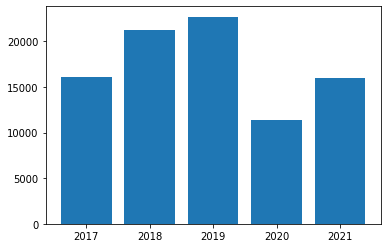

In [78]:
import matplotlib.pyplot as plt
plt.bar(complete_data['Year'], complete_data['Year Total'])
plt.show()